In [1]:
import os
import numpy as np

SAVE_PATH = "/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/Model_softmax/Uncertainty_Rand_300_T_1000_Path_4/class_results"


def class_numeric_key(folder_name):
    return int(folder_name.split("_")[1])


# ----------------------------------------
# Load ALL classes
# ----------------------------------------
y_true_list = []
y_pred_list = []
post_mean_list = []
post_sem_list = []

class_folders = sorted(
    [d for d in os.listdir(SAVE_PATH) if d.startswith("class_")],
    key=class_numeric_key
)

for class_dir in class_folders:
    class_path = os.path.join(SAVE_PATH, class_dir)

    # Load the first 200 samples per class (your rule)
    y_true = np.load(os.path.join(class_path, "y_true.npy"))
    y_pred = np.load(os.path.join(class_path, "y_pred.npy"))
    post_mean = np.load(os.path.join(class_path, "posteriors_mean.npy"))
    post_sem  = np.load(os.path.join(class_path, "posteriors_sem.npy"))

    y_true_list.append(y_true)
    y_pred_list.append(y_pred)
    post_mean_list.append(post_mean)
    post_sem_list.append(post_sem)


# ----------------------------------------
# Final concatenated arrays
# ----------------------------------------
y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)
posteriors_mean = np.concatenate(post_mean_list)  # shape [N, num_classes]
posteriors_sem = np.concatenate(post_sem_list)    # shape [N, num_classes]

print("Loaded samples:", len(y_true))
print("posteriors_mean shape:", posteriors_mean.shape)
print("posteriors_sem shape:", posteriors_sem.shape)

Loaded samples: 49046
posteriors_mean shape: (49046, 164)
posteriors_sem shape: (49046, 164)


In [2]:
# Use mean + SEM arrays generated by your new inference script
y_true_arr = y_true               # shape [N]
y_pred_arr = y_pred               # shape [N]
post_mean_arr = posteriors_mean   # shape [N, num_classes]
post_sem_arr  = posteriors_sem    # shape [N, num_classes]

y_pred_adjusted = y_pred_arr.copy()

for i in range(len(y_true_arr)):
    true_label = y_true_arr[i]
    
    posterior_mean = post_mean_arr[i]   # [num_classes]
    posterior_sem  = post_sem_arr[i]    # [num_classes]
    
    max_post = posterior_mean.max()
    
    # UNCERTAINTY RULE:
    # true class is considered correct if:
    # posterior_mean(true) >= max(posterior_mean) - SEM(true)
    if posterior_mean[true_label] >= max_post - posterior_sem[true_label]:
        y_pred_adjusted[i] = true_label

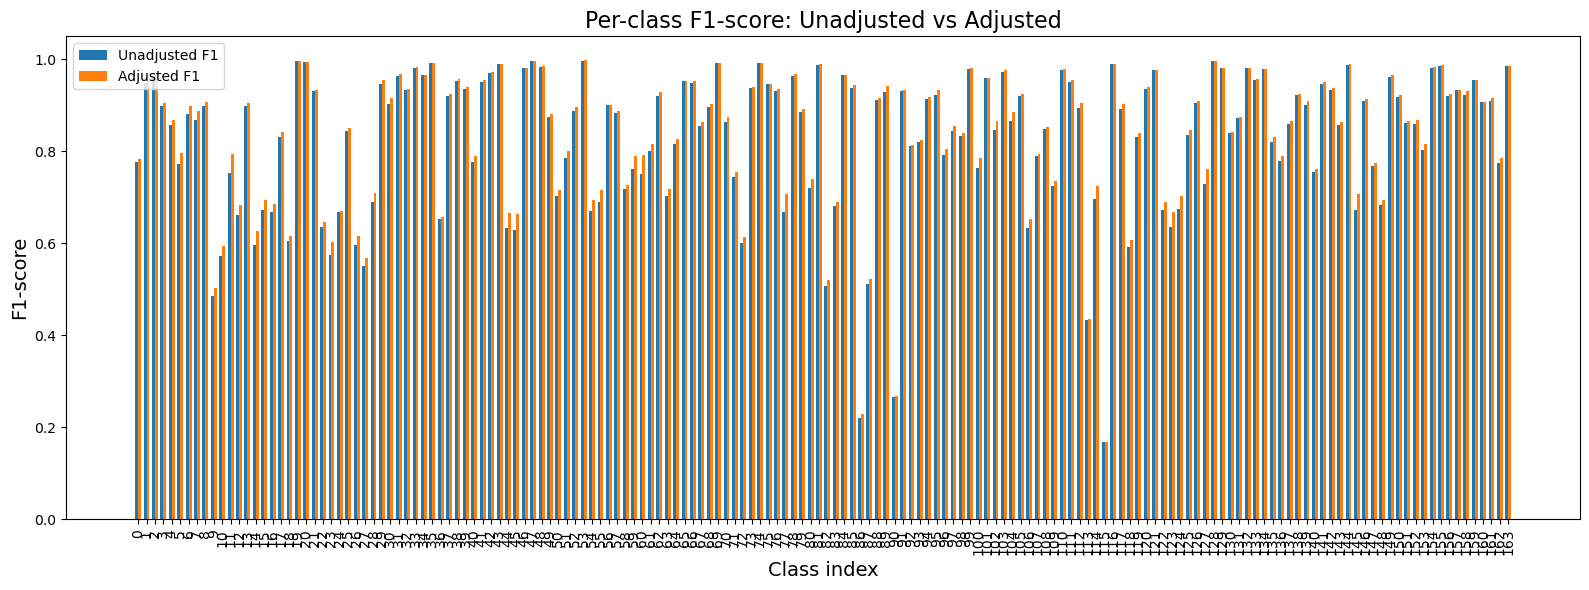

Macro F1 (original): 0.8283231550924331
Macro F1 (adjusted): 0.8377792632559925


In [3]:
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 1. Compute per-class F1 (unadjusted vs adjusted)
# -------------------------------------------------------
# Ensure arrays are numpy arrays
y_true_arr = np.array(y_true_arr)
y_pred_arr = np.array(y_pred_arr)
y_pred_adjusted = np.array(y_pred_adjusted)

num_classes = np.unique(y_true_arr).size
class_ids = np.arange(num_classes)

f1_unadjusted_pc = f1_score(
    y_true_arr, y_pred_arr, average=None, labels=class_ids
)

f1_adjusted_pc = f1_score(
    y_true_arr, y_pred_adjusted, average=None, labels=class_ids
)

# -------------------------------------------------------
# 2. Plot side-by-side per-class histogram bars
# -------------------------------------------------------
plt.figure(figsize=(16, 6))
width = 0.35
x = np.arange(num_classes)

plt.bar(x - width/2, f1_unadjusted_pc, width=width, label="Unadjusted F1")
plt.bar(x + width/2, f1_adjusted_pc, width=width, label="Adjusted F1")

plt.xlabel("Class index", fontsize=14)
plt.ylabel("F1-score", fontsize=14)
plt.title("Per-class F1-score: Unadjusted vs Adjusted", fontsize=16)
plt.xticks(x, x, rotation=90)
plt.ylim(0, 1.05)
plt.legend()
# plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.savefig("tie_adjustment.png", dpi=150)
plt.savefig("tie_adjustment.svg", dpi=150)
plt.tight_layout()
plt.show()

print("Macro F1 (original):", np.mean(f1_unadjusted_pc))
print("Macro F1 (adjusted):", np.mean(f1_adjusted_pc))

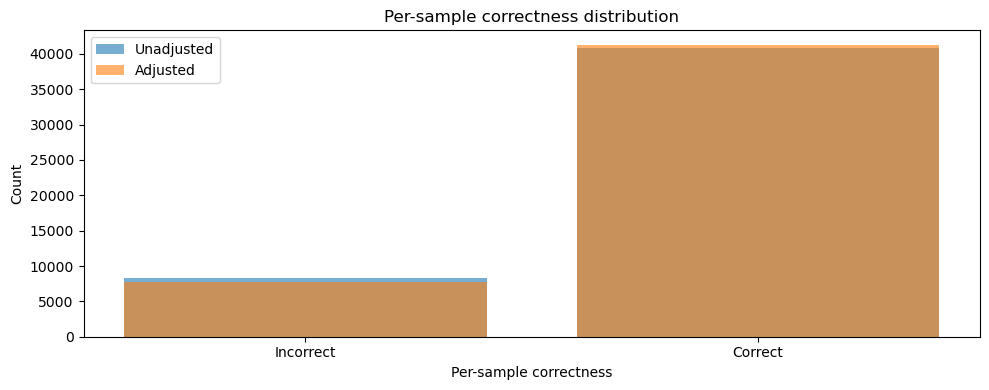

Accuracy (original): 0.8318313420054643
Accuracy (adjusted): 0.8416180728295886


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Per-sample correctness before & after adjustment
correct_unadjusted = (y_pred_arr == y_true_arr).astype(int)
correct_adjusted   = (y_pred_adjusted == y_true_arr).astype(int)

plt.figure(figsize=(10, 4))
plt.hist(correct_unadjusted, bins=[-0.5, 0.5, 1.5],
         alpha=0.6, label="Unadjusted", rwidth=0.8)
plt.hist(correct_adjusted, bins=[-0.5, 0.5, 1.5],
         alpha=0.6, label="Adjusted", rwidth=0.8)

plt.xticks([0, 1], ["Incorrect", "Correct"])
plt.xlabel("Per-sample correctness")
plt.ylabel("Count")
plt.title("Per-sample correctness distribution")
plt.legend()
plt.tight_layout()
plt.savefig("per_sample_correctness_hist.png", dpi=150)
plt.show()

print("Accuracy (original):", correct_unadjusted.mean())
print("Accuracy (adjusted):", correct_adjusted.mean())

In [5]:
import numpy as np

y_true = np.array(y_true_arr)
y_pred = np.array(y_pred_arr)

num_classes = np.unique(y_true).size
N = len(y_true)

# Count samples per class
class_counts = np.bincount(y_true, minlength=num_classes)

# Per-sample contribution array
sample_f1_contrib = np.zeros(N, dtype=float)

for i in range(N):
    true_label = y_true[i]
    if y_pred[i] == true_label:
        sample_f1_contrib[i] = 1.0 / class_counts[true_label]
    else:
        sample_f1_contrib[i] = 0.0


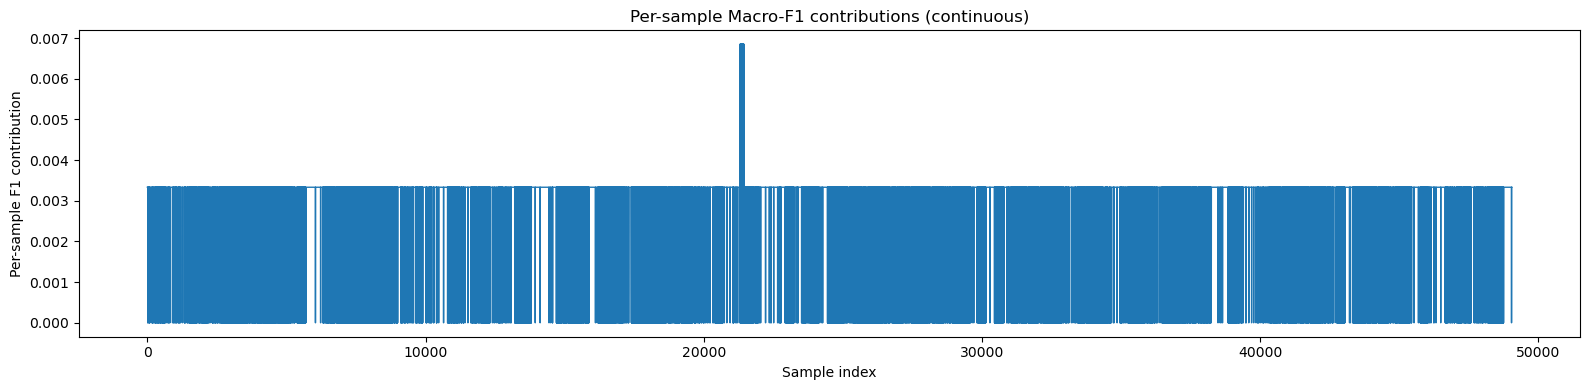

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,4))
plt.plot(sample_f1_contrib, lw=1)
plt.xlabel("Sample index")
plt.ylabel("Per-sample F1 contribution")
plt.title("Per-sample Macro-F1 contributions (continuous)")
plt.tight_layout()
plt.savefig("per_sample_f1_contribution.png", dpi=150)
plt.show()

In [7]:
import numpy as np

y_true = np.array(y_true_arr)
y_pred = np.array(y_pred_arr)
y_pred_adj = np.array(y_pred_adjusted)

num_classes = np.unique(y_true).size
N = len(y_true)

# class sample counts
class_counts = np.bincount(y_true, minlength=num_classes)

# per-sample F1 contributions
f1_per_sample = np.zeros(N)
f1_per_sample_adj = np.zeros(N)

for i in range(N):
    c = y_true[i]
    if y_pred[i] == c:
        f1_per_sample[i] = 1.0 / class_counts[c]
    if y_pred_adj[i] == c:
        f1_per_sample_adj[i] = 1.0 / class_counts[c]


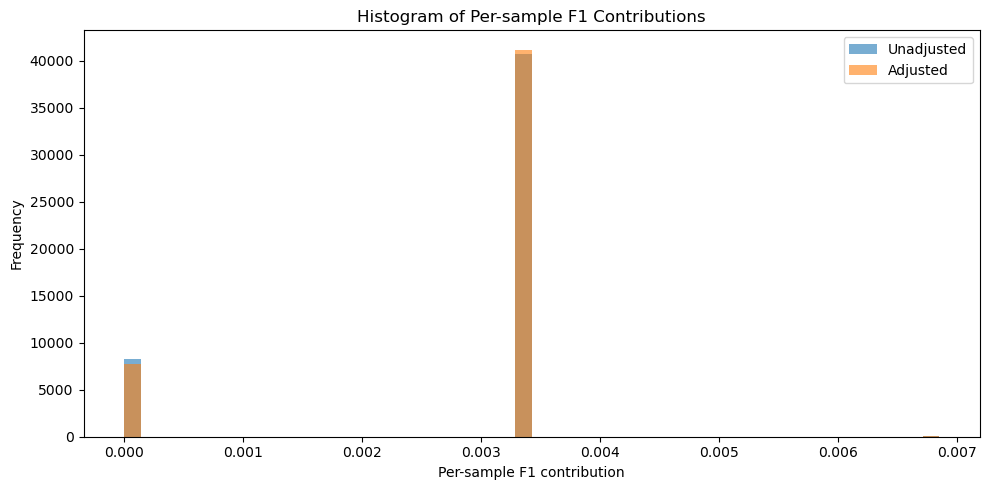

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(f1_per_sample, bins=50, alpha=0.6, label="Unadjusted")
plt.hist(f1_per_sample_adj, bins=50, alpha=0.6, label="Adjusted")

plt.xlabel("Per-sample F1 contribution")
plt.ylabel("Frequency")
plt.title("Histogram of Per-sample F1 Contributions")
plt.legend()
plt.tight_layout()
plt.savefig("per_sample_f1_histogram.png", dpi=150)
plt.show()
